In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [77]:
print("="*80)
print("WCZYTYWANIE DANYCH")
print("="*80)

# Główne datasety - KODY JAKO STRING!
df_complete = pd.read_csv('./output/complete_dataset.csv', dtype={'powiat_code': str})
df_ml_ready = pd.read_csv('./output/ml_ready_dataset.csv', dtype={'powiat_code': str})
df_2024 = pd.read_csv('./output/complete_dataset_2024.csv', dtype={'powiat_code': str})

# Szczegółowe datasety - KODY JAKO STRING!
df_crime_counts = pd.read_csv('./output/crime/crime_counts_powiaty.csv', dtype={'region_code': str})
df_crime_detection = pd.read_csv('./output/crime/crime_detection_rates_powiaty.csv', dtype={'region_code': str})
df_population = pd.read_csv('./output/population/population_with_density.csv', dtype={'powiat_code': str})
df_unemployment = pd.read_csv('./output/socio/unemployment_powiaty.csv', dtype={'powiat_code': str})
df_wages = pd.read_csv('./output/socio/wages_powiaty.csv', dtype={'powiat_code': str})

print(f"\n✓ Wczytano complete_dataset: {df_complete.shape}")
print(f"✓ Wczytano ml_ready_dataset: {df_ml_ready.shape}")
print(f"✓ Wczytano complete_dataset_2024: {df_2024.shape}")
print(f"✓ Wczytano crime_counts: {df_crime_counts.shape}")
print(f"✓ Wczytano crime_detection: {df_crime_detection.shape}")

WCZYTYWANIE DANYCH

✓ Wczytano complete_dataset: (4752, 29)
✓ Wczytano ml_ready_dataset: (3179, 29)
✓ Wczytano complete_dataset_2024: (396, 29)
✓ Wczytano crime_counts: (38016, 5)
✓ Wczytano crime_detection: (42768, 5)


In [78]:
print("\n" + "="*80)
print("PODSTAWOWE STATYSTYKI - COMPLETE DATASET")
print("="*80)

print("\n--- Informacje o datasecie ---")
print(f"Okres danych: {df_complete['year'].min()} - {df_complete['year'].max()}")
print(f"Liczba powiatów: {df_complete['powiat_code'].nunique()}")
print(f"Liczba lat: {df_complete['year'].nunique()}")
print(f"Całkowita liczba rekordów: {len(df_complete)}")
print(f"Braki danych: {df_complete.isnull().sum().sum()} ({df_complete.isnull().sum().sum() / df_complete.size * 100:.2f}%)")

print("\n--- Statystyki crime_rate_per_100k ---")
print(df_complete['crime_rate_per_100k'].describe())

print("\n--- Top 5 kolumn z brakami danych ---")
missing_cols = df_complete.isnull().sum().sort_values(ascending=False).head()
print(missing_cols[missing_cols > 0])

print("\n--- Rozkład danych po latach ---")
print(df_complete['year'].value_counts().sort_index())


PODSTAWOWE STATYSTYKI - COMPLETE DATASET

--- Informacje o datasecie ---
Okres danych: 2013 - 2024
Liczba powiatów: 396
Liczba lat: 12
Całkowita liczba rekordów: 4752
Braki danych: 11074 (8.04%)

--- Statystyki crime_rate_per_100k ---
count     4560.000000
mean      3292.438044
std       1669.614240
min        851.300000
25%       2323.575000
50%       2972.160000
75%       3839.130000
max      37248.580000
Name: crime_rate_per_100k, dtype: float64

--- Top 5 kolumn z brakami danych ---
wage_category            1142
wage_index               1140
unemployment_rate        1140
unemployment_category    1140
social_risk_score        1140
dtype: int64

--- Rozkład danych po latach ---
year
2013    396
2014    396
2015    396
2016    396
2017    396
2018    396
2019    396
2020    396
2021    396
2022    396
2023    396
2024    396
Name: count, dtype: int64


In [79]:
print("\n" + "="*80)
print("STATYSTYKI ML_READY DATASET (bez braków)")
print("="*80)

print(f"\nLiczba rekordów: {len(df_ml_ready)}")
print(f"Usunięto rekordów z brakami: {len(df_complete) - len(df_ml_ready)}")

print("\n--- Statystyki kluczowych features ---")
key_features = ['crime_rate_per_100k', 'population_density', 'unemployment_rate', 
                'wage_index', 'youth_ratio', 'gender_ratio']
print(df_ml_ready[key_features].describe())


STATYSTYKI ML_READY DATASET (bez braków)

Liczba rekordów: 3179
Usunięto rekordów z brakami: 1573

--- Statystyki kluczowych features ---
       crime_rate_per_100k  population_density  unemployment_rate  \
count          3179.000000         3179.000000        3179.000000   
mean           3121.189566          381.197763           8.671972   
std            1691.390495          666.081555           5.033246   
min             851.300000           17.930000           1.000000   
25%            2226.655000           59.790000           5.000000   
50%            2833.680000           97.290000           7.500000   
75%            3595.080000          212.580000          11.300000   
max           37248.580000         3961.080000          34.400000   

        wage_index  youth_ratio  gender_ratio  
count  3179.000000  3179.000000   3179.000000  
mean     86.139509     0.173687     95.578795  
std      10.900648     0.022549      3.455629  
min       0.000000     0.115200     83.500000  

In [80]:
print("\n" + "="*80)
print("TRENDY CZASOWE - PRZESTĘPCZOŚĆ W POLSCE")
print("="*80)

# Agregacja danych rocznych dla całej Polski
yearly_stats = df_complete.groupby('year').agg({
    'crime_rate_per_100k': 'mean',
    'total_crimes': 'sum',
    'total_population': 'sum',
    'unemployment_rate': 'mean',
    'wage_index': 'mean'
}).reset_index()

print("\n--- Średni wskaźnik przestępczości w Polsce (rok po roku) ---")
print(yearly_stats[['year', 'crime_rate_per_100k', 'total_crimes']])

# Obliczenie zmian rok do roku
yearly_stats['crime_change_pct'] = yearly_stats['crime_rate_per_100k'].pct_change() * 100
yearly_stats['unemployment_change_pct'] = yearly_stats['unemployment_rate'].pct_change() * 100

print("\n--- Procentowe zmiany rok do roku ---")
print(yearly_stats[['year', 'crime_change_pct', 'unemployment_change_pct']].dropna())


TRENDY CZASOWE - PRZESTĘPCZOŚĆ W POLSCE

--- Średni wskaźnik przestępczości w Polsce (rok po roku) ---
    year  crime_rate_per_100k  total_crimes
0   2013          4332.268368     3680852.0
1   2014          3436.289921     2970496.0
2   2015          3181.244132     2724804.0
3   2016          2956.643579     2528936.0
4   2017          2957.256947     2512130.0
5   2018          3096.006895     2595094.0
6   2019          3188.265447     2709252.0
7   2020          3218.004316     2570476.0
8   2021          3360.656658     2771642.0
9   2022          3495.150868     2850072.0
10  2023          3210.198421     2646452.0
11  2024          3077.270974     2483968.0

--- Procentowe zmiany rok do roku ---
    year  crime_change_pct  unemployment_change_pct
1   2014        -20.681508               -14.124153
2   2015         -7.422127               -13.089474
3   2016         -7.060148               -14.562268
4   2017          0.020745               -18.524435
5   2018          4.69184

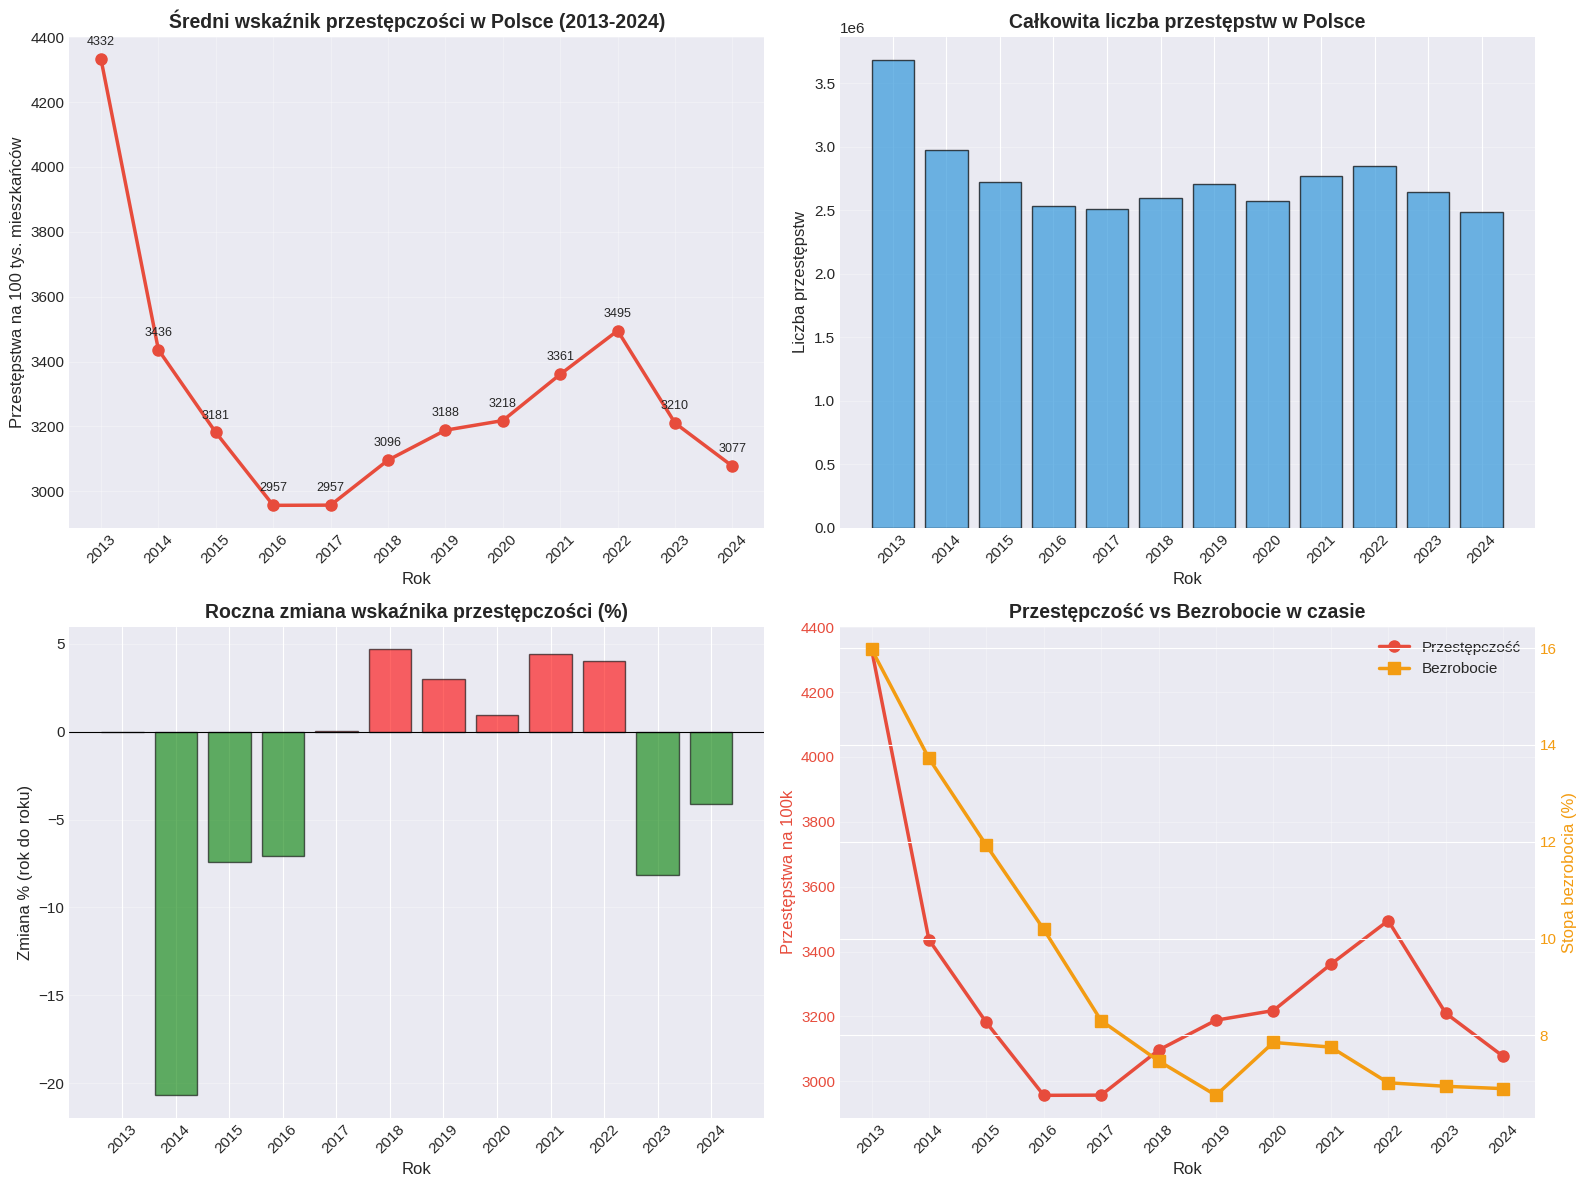


✓ Wykres zapisany jako 'trendy_czasowe_polska.png'


In [81]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Wykres 1: Średni wskaźnik przestępczości w Polsce
ax1 = axes[0, 0]
ax1.plot(yearly_stats['year'], yearly_stats['crime_rate_per_100k'], 
         marker='o', linewidth=2.5, markersize=8, color='#e74c3c')
ax1.set_title('Średni wskaźnik przestępczości w Polsce (2013-2024)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Rok', fontsize=12)
ax1.set_ylabel('Przestępstwa na 100 tys. mieszkańców', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(yearly_stats['year'])
ax1.set_xticklabels(yearly_stats['year'], rotation=45)

# Dodanie wartości na wykresie
for x, y in zip(yearly_stats['year'], yearly_stats['crime_rate_per_100k']):
    ax1.annotate(f'{y:.0f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

# Wykres 2: Całkowita liczba przestępstw
ax2 = axes[0, 1]
ax2.bar(yearly_stats['year'], yearly_stats['total_crimes'], 
        color='#3498db', alpha=0.7, edgecolor='black')
ax2.set_title('Całkowita liczba przestępstw w Polsce', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Rok', fontsize=12)
ax2.set_ylabel('Liczba przestępstw', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(yearly_stats['year'])
ax2.set_xticklabels(yearly_stats['year'], rotation=45)

# Wykres 3: Procentowa zmiana rok do roku
ax3 = axes[1, 0]
colors = ['green' if x < 0 else 'red' for x in yearly_stats['crime_change_pct'].fillna(0)]
ax3.bar(yearly_stats['year'], yearly_stats['crime_change_pct'].fillna(0), 
        color=colors, alpha=0.6, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.set_title('Roczna zmiana wskaźnika przestępczości (%)', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel('Rok', fontsize=12)
ax3.set_ylabel('Zmiana % (rok do roku)', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(yearly_stats['year'])
ax3.set_xticklabels(yearly_stats['year'], rotation=45)

# Wykres 4: Przestępczość vs Bezrobocie
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

line1 = ax4.plot(yearly_stats['year'], yearly_stats['crime_rate_per_100k'], 
                 marker='o', linewidth=2.5, markersize=8, color='#e74c3c', label='Przestępczość')
line2 = ax4_twin.plot(yearly_stats['year'], yearly_stats['unemployment_rate'], 
                      marker='s', linewidth=2.5, markersize=8, color='#f39c12', label='Bezrobocie')

ax4.set_title('Przestępczość vs Bezrobocie w czasie', 
              fontsize=14, fontweight='bold')
ax4.set_xlabel('Rok', fontsize=12)
ax4.set_ylabel('Przestępstwa na 100k', fontsize=12, color='#e74c3c')
ax4_twin.set_ylabel('Stopa bezrobocia (%)', fontsize=12, color='#f39c12')
ax4.tick_params(axis='y', labelcolor='#e74c3c')
ax4_twin.tick_params(axis='y', labelcolor='#f39c12')
ax4.grid(True, alpha=0.3)
ax4.set_xticks(yearly_stats['year'])
ax4.set_xticklabels(yearly_stats['year'], rotation=45)

# Legenda
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.savefig('./output/imgs/trendy_czasowe_polska.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres zapisany jako 'trendy_czasowe_polska.png'")

In [82]:
print("\n" + "="*80)
print("TRENDY PO WOJEWÓDZTWACH")
print("="*80)

# Ekstrakcja województwa z nazwy powiatu (pierwsze 2 znaki kodu TERYT)
df_complete["wojewodztwo_code"] = df_complete["powiat_code"].astype(str).str.zfill(7).str[:2]

# Mapowanie kodów województw na nazwy
wojewodztwa_map = {
    '02': 'dolnośląskie', '04': 'kujawsko-pomorskie', '06': 'lubelskie',
    '08': 'lubuskie', '10': 'łódzkie', '12': 'małopolskie',
    '14': 'mazowieckie', '16': 'opolskie', '18': 'podkarpackie',
    '20': 'podlaskie', '22': 'pomorskie', '24': 'śląskie',
    '26': 'świętokrzyskie', '28': 'warmińsko-mazurskie', '30': 'wielkopolskie',
    '32': 'zachodniopomorskie'
}

df_complete['wojewodztwo'] = df_complete['wojewodztwo_code'].map(wojewodztwa_map)

# Filtruj tylko powiaty (wykluczamy województwa które kończą się na 00000)
df_only_powiaty = df_complete[df_complete['powiat_code'].astype(str).str.endswith('00000') == False].copy()

# Grupuj i oblicz wskaźnik przestępczości
wojewodztwa_yearly = df_only_powiaty.groupby(['wojewodztwo', 'year']).apply(
    lambda x: pd.Series({
        'crime_rate_per_100k': (x['total_crimes'].sum() / x['total_population'].sum() * 100000)
    }), include_groups=False
).reset_index()

# Filtruj 2024
wojewodztwa_2024 = wojewodztwa_yearly[wojewodztwa_yearly['year'] == 2024].sort_values(
    'crime_rate_per_100k', ascending=False
)

print("\n--- TOP 5 Województw z najwyższą przestępczością (2024) ---")
print(wojewodztwa_2024.head().to_string(index=False))

print("\n--- TOP 5 Województw z najniższą przestępczością (2024) ---")
print(wojewodztwa_2024.tail().to_string(index=False))

print("\n--- Wszystkie wojewodztwa ---")
print(wojewodztwa_2024)


TRENDY PO WOJEWÓDZTWACH

--- TOP 5 Województw z najwyższą przestępczością (2024) ---
 wojewodztwo  year  crime_rate_per_100k
dolnośląskie  2024          4309.538735
    lubuskie  2024          3982.805039
     śląskie  2024          3833.304477
   pomorskie  2024          3685.198473
 mazowieckie  2024          3557.635156

--- TOP 5 Województw z najniższą przestępczością (2024) ---
   wojewodztwo  year  crime_rate_per_100k
      opolskie  2024          2807.493529
świętokrzyskie  2024          2541.211460
     lubelskie  2024          2540.171505
     podlaskie  2024          2418.859992
  podkarpackie  2024          1995.349484

--- Wszystkie wojewodztwa ---
             wojewodztwo  year  crime_rate_per_100k
11          dolnośląskie  2024          4309.538735
47              lubuskie  2024          3982.805039
179              śląskie  2024          3833.304477
119            pomorskie  2024          3685.198473
59           mazowieckie  2024          3557.635156
71           małop

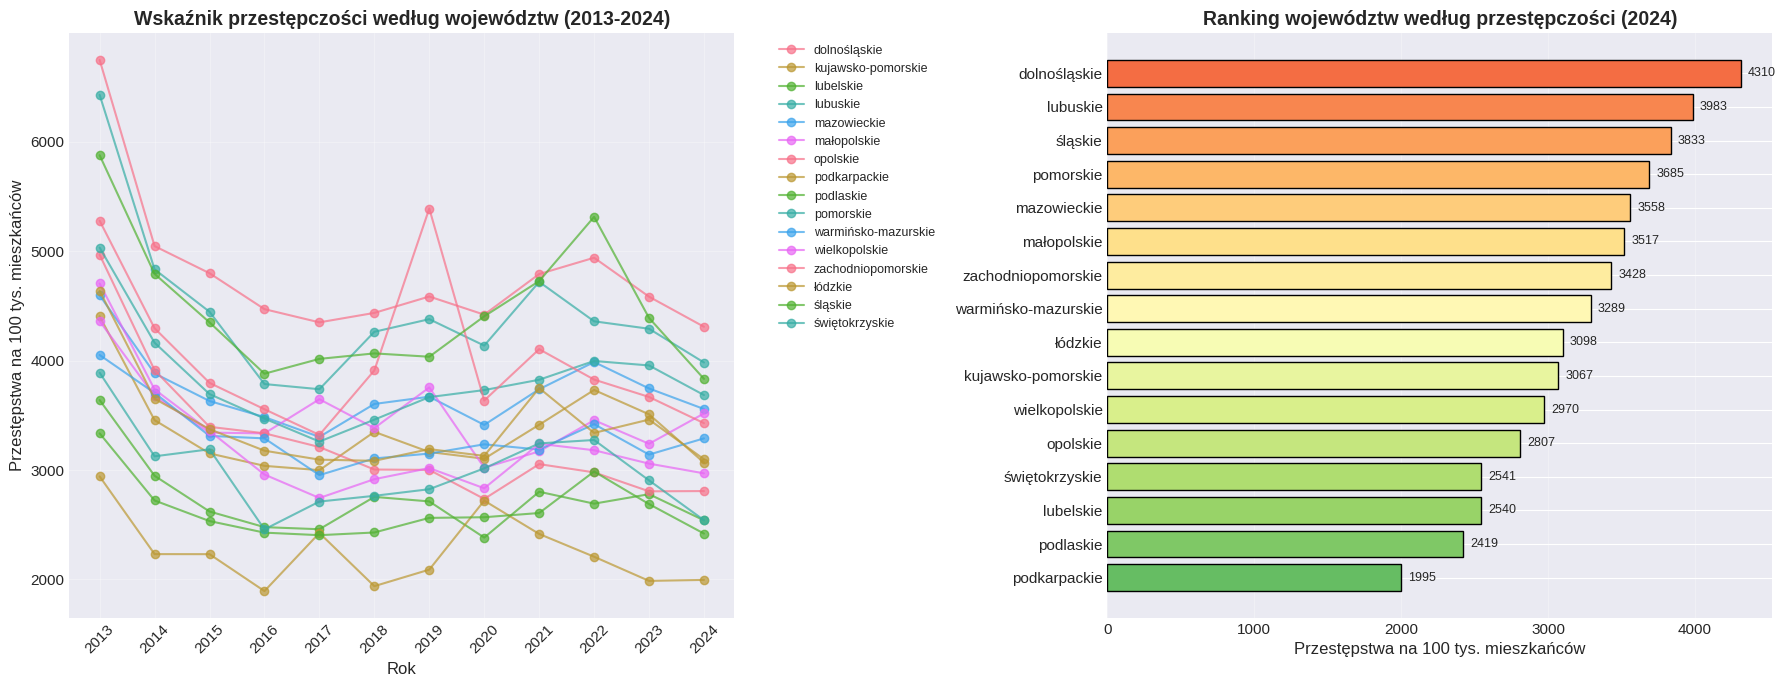


✓ Wykres zapisany jako 'trendy_wojewodztwa.png'


In [83]:
# Wykres liniowy - wszystkie województwa
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

ax1 = axes[0]
for woj in wojewodztwa_yearly['wojewodztwo'].unique():
    if pd.notna(woj):
        woj_data = wojewodztwa_yearly[wojewodztwa_yearly['wojewodztwo'] == woj]
        ax1.plot(woj_data['year'], woj_data['crime_rate_per_100k'], 
                marker='o', linewidth=1.5, label=woj, alpha=0.7)

ax1.set_title('Wskaźnik przestępczości według województw (2013-2024)', 
             fontsize=14, fontweight='bold')
ax1.set_xlabel('Rok', fontsize=12)
ax1.set_ylabel('Przestępstwa na 100 tys. mieszkańców', fontsize=12)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(wojewodztwa_yearly['year'].unique())
ax1.set_xticklabels(wojewodztwa_yearly['year'].unique(), rotation=45)

# Wykres słupkowy - ranking 2024
ax2 = axes[1]
wojewodztwa_2024_sorted = wojewodztwa_2024.sort_values('crime_rate_per_100k')
colors_woj = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(wojewodztwa_2024_sorted)))

ax2.barh(wojewodztwa_2024_sorted['wojewodztwo'], 
        wojewodztwa_2024_sorted['crime_rate_per_100k'],
        color=colors_woj, edgecolor='black')
ax2.set_title('Ranking województw według przestępczości (2024)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Przestępstwa na 100 tys. mieszkańców', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

# Dodanie wartości na wykresie
for i, (woj, val) in enumerate(zip(wojewodztwa_2024_sorted['wojewodztwo'], 
                                    wojewodztwa_2024_sorted['crime_rate_per_100k'])):
    ax2.text(val + 50, i, f'{val:.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('./output/imgs/trendy_wojewodztwa.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres zapisany jako 'trendy_wojewodztwa.png'")

In [84]:
print("\n" + "="*80)
print("PODSUMOWANIE ANALIZY TRENDÓW CZASOWYCH")
print("="*80)

# Ogólny trend
first_year = yearly_stats.iloc[0]
last_year = yearly_stats.iloc[-1]
total_change = ((last_year['crime_rate_per_100k'] - first_year['crime_rate_per_100k']) / 
                first_year['crime_rate_per_100k'] * 100)

print(f"\n📊 POLSKA OGÓŁEM:")
print(f"   Wskaźnik przestępczości {int(first_year['year'])}: {first_year['crime_rate_per_100k']:.0f}")
print(f"   Wskaźnik przestępczości {int(last_year['year'])}: {last_year['crime_rate_per_100k']:.0f}")
print(f"   Zmiana całkowita: {total_change:+.1f}%")

# Rok z najwyższą i najniższą przestępczością
max_crime_year = yearly_stats.loc[yearly_stats['crime_rate_per_100k'].idxmax()]
min_crime_year = yearly_stats.loc[yearly_stats['crime_rate_per_100k'].idxmin()]

print(f"\n   Rok z najwyższą przestępczością: {int(max_crime_year['year'])} ({max_crime_year['crime_rate_per_100k']:.0f})")
print(f"   Rok z najniższą przestępczością: {int(min_crime_year['year'])} ({min_crime_year['crime_rate_per_100k']:.0f})")

# Trend bezrobocia
unemployment_change = ((last_year['unemployment_rate'] - first_year['unemployment_rate']) / 
                      first_year['unemployment_rate'] * 100)
print(f"\n📉 BEZROBOCIE:")
print(f"   Stopa bezrobocia {int(first_year['year'])}: {first_year['unemployment_rate']:.1f}%")
print(f"   Stopa bezrobocia {int(last_year['year'])}: {last_year['unemployment_rate']:.1f}%")
print(f"   Zmiana: {unemployment_change:+.1f}%")

print("\n" + "="*80)
print("CZĘŚĆ 1 ZAKOŃCZONA - Trendy czasowe")
print("="*80)


PODSUMOWANIE ANALIZY TRENDÓW CZASOWYCH

📊 POLSKA OGÓŁEM:
   Wskaźnik przestępczości 2013: 4332
   Wskaźnik przestępczości 2024: 3077
   Zmiana całkowita: -29.0%

   Rok z najwyższą przestępczością: 2013 (4332)
   Rok z najniższą przestępczością: 2016 (2957)

📉 BEZROBOCIE:
   Stopa bezrobocia 2013: 16.0%
   Stopa bezrobocia 2024: 6.9%
   Zmiana: -56.8%

CZĘŚĆ 1 ZAKOŃCZONA - Trendy czasowe
